In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as TTS
import pymc3 as pm

In [2]:
%matplotlib inline

In [3]:
dfMC = pd.read_pickle('dfMergedAndCleaned.pkl')

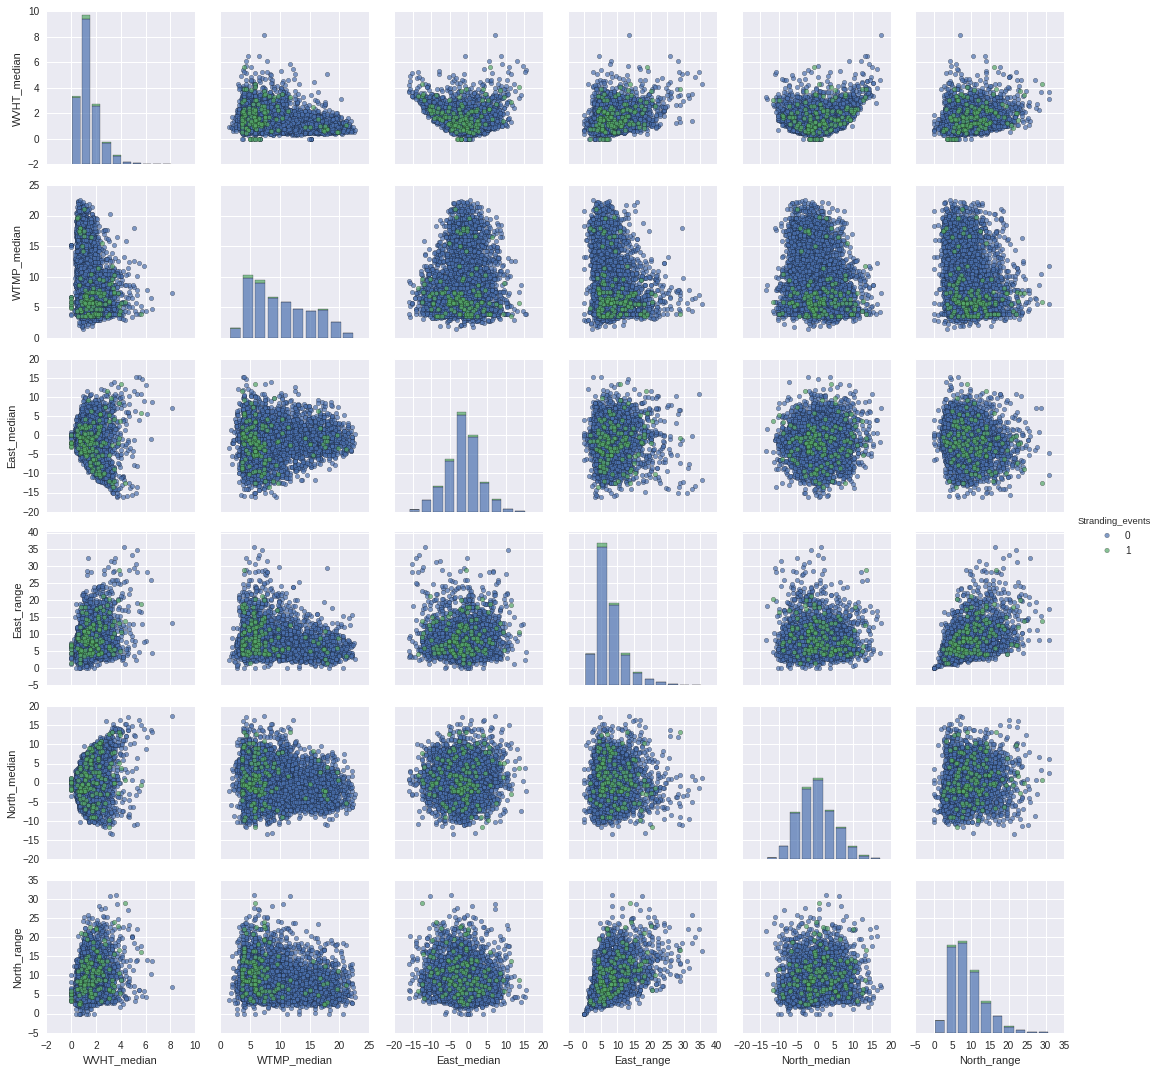

In [4]:
g = sb.PairGrid(dfMC, vars=['WVHT_median', 'WTMP_median',
                                       'East_median', 'East_range',
                                       'North_median', 'North_range'],hue='Stranding_events')
gdiag = g.map_diag(pl.hist, alpha=0.7)
godiag = g.map_offdiag(pl.scatter, alpha=0.7, edgecolor='k')
g.add_legend();

In [ ]:
#WTMP_median looks pretty promising start with that but first, some preprocessing

In [5]:
features=['WVHT_median', 'WTMP_median', 'East_median', 'East_range', 'North_median', 'North_range']
X = dfMC[features].values
y = dfMC.Stranding_events.values

In [6]:
X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.33, random_state=45)

In [7]:
scaler = StandardScaler()

In [8]:
X_train_sc = scaler.fit_transform(X_train)

Start with logistic regression with single feature, WTMP_median.

In [9]:
X_wtmp_sc = X_train_sc[:,1]

In [31]:
with pm.Model() as mlog1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    mu = alpha + X_wtmp_sc * beta
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    decBound = pm.Deterministic('decBound', -alpha/beta)
    y_pred = pm.Binomial('y_pred', n=y_train.size, p=theta, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS()
    tracelog1 = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 369.498983
         Iterations: 40
         Function evaluations: 45
         Gradient evaluations: 45


100%|██████████| 5500/5500 [00:35<00:00, 154.95it/s]


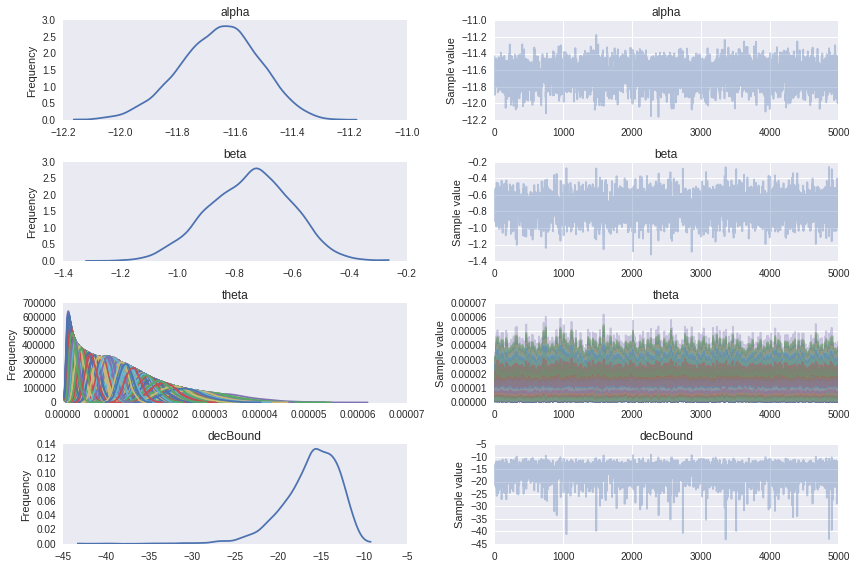

In [32]:
pm.traceplot(tracelog1);

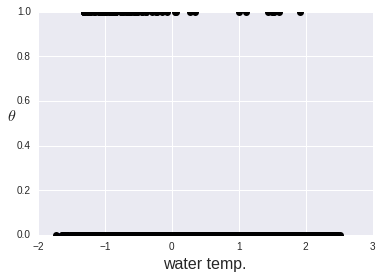

In [34]:
theta = tracelog1['theta'].mean(axis=0)
idx = np.argsort(X_wtmp_sc)
pl.plot(X_wtmp_sc[idx], theta[idx], color='b', lw=3);
#pl.axvline(tracelog1['decBound'].mean(), ymax=1, color="r")
#bd_hpd = pm.hpd(tracelog1['decBound'])
#pl.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)
pl.plot(X_wtmp_sc, y_train, 'ko')
theta_hpd = pm.hpd(tracelog1['theta'])[idx]
pl.fill_between(X_wtmp_sc[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)
pl.xlabel('water temp.', fontsize=16)
pl.ylabel(r'$\theta$', rotation=0, fontsize=16)